In [253]:
import sys
import os
import urllib

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

# Protein Bioinformatics- Day 2

In [1]:
from Bio.PDB import *

## Structure Loader
We define a function to download PDBs from RCSB. It should either take as argument a list of structure ids or a single structure id (default).

In [125]:
def structure_loader(structure_id, temp_folder="./temp"):
    # Build a temporary directory to store the pdbs
    if not os.path.isdir(temp_folder):
        os.makedirs(temp_folder)
        
    # Handle the different cases for structure id, default is string, if
    # it is a list of a tuple, we return a list of structures.
    if isinstance(structure_id, (list, tuple)):
        return [structure_loader(el) for el in structure_id]
    elif not isinstance(structure_id, str):
        raise NotImplementedError()
        
    # Download and store the PDB file
    url_path = "https://files.rcsb.org/download/" + structure_id.lower() + ".pdb"
    file_path = os.path.join(temp_folder, structure_id)
    if not os.path.isfile(file_path):
        urllib.request.urlretrieve(url_path, file_path)
        
    # Parse the PDB file and return its structure
    pdb_parser = PDBParser()
    structure = pdb_parser.get_structure(structure_id.upper(), file_path)
    
    return structure

In [133]:
my_prot = structure_loader('6gwi')

## Summary Info
We define a function to obtain a summary of the structure. It should either take as argument a list of structure or a single structure (default).

In [178]:
def structure_summaries(structure):
    if isinstance(structure, (list, tuple)):
        return [structure_summary(el) for el in structure]
    elif not isinstance(structure, Structure.Structure):
        raise NotImplementedError()
        
    return [(structure.id, _chain_summary_(chain)) for chain in structure[0]]
    
def _chain_summary_(chain):
    residues = [res for res in chain.get_residues() if is_aa(res)]
    counts = {res.get_resname(): 0 for res in set(residues)}
    for res in residues:
        counts[res.get_resname()] += 1
    
    summary = {}
    summary['len'] = len(chain)
    summary['nRes'] = len(residues)
    summary['counts'] = counts
    
    return summary
    
def print_summary(structure_id, summary):
    print("Structure id".ljust(20, '.') + 
             str(structure_id).rjust(10, '.'))
    print("Length".ljust(20, '.') +
             str(summary['len']).rjust(10, '.'))
    print("Number of residues".ljust(20, '.') +
             str(summary['nRes']).rjust(10, '.'))
    
    plt.bar(range(len(summary['counts'])),
                [val for val in summary['counts'].values()],
            tick_label=[res for res in summary['counts'].keys()])
    plt.xticks(rotation = 45)
    plt.show()

Structure id..............6GWI
Length.....................538
Number of residues.........449


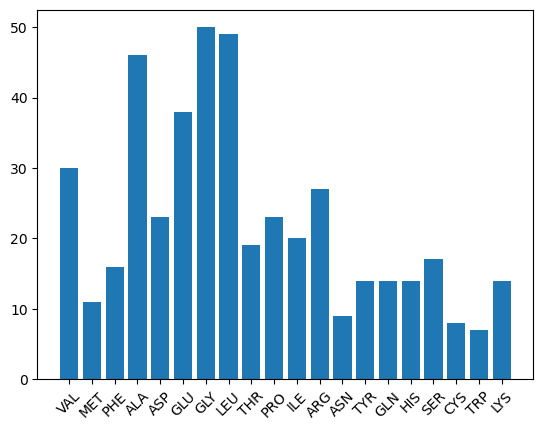

In [179]:
my_summ = structure_summaries(my_prot)
print_summary(*my_summ[0])

## Secondary Structure

In [251]:
def secondary_structures(structure):
    if isinstance(structure, (list, tuple)):
        return [secondary_structures(el) for el in structure]
    elif not isinstance(structure, Structure.Structure):
        raise NotImplementedError()
        
    return [(structure.id, _secondary_structure_(chain)) for chain in structure[0]]

def _secondary_structure_(chain):
    residues = [res for res in chain.get_residues() if is_aa(res)]
    vecC = [res["C"].get_vector() for res in residues]
    vecCA = [res["CA"].get_vector() for res in residues]
    vecN = [res["N"].get_vector() for res in residues]
    
    phi = np.array([calc_dihedral(vecC[i], vecC[i-1], vecCA[i], vecN[i]) for i in range(1, len(residues))])
    phi = np.degrees(phi)
    psi = np.array([calc_dihedral(vecC[i], vecCA[i], vecN[i], vecN[i+1]) for i in range(len(residues)-1)])
    psi = np.degrees(psi)
    
    return phi, psi

def print_secondary_structure(structure_id, secondary_structure):
    # background code inspired from https://github.com/alxdrcirilo/RamachanDraw/
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    
    background = np.fromfile('./density_estimate.dat').reshape(100, 100)
    ax.imshow(np.log(np.rot90(background)), extent=[-180, 180, -180, 180], alpha=.7)
    ax.contour(np.rot90(np.fliplr(background)), colors='k', linewidth=.5, 
               levels=[10 ** i for i in range(-7, 0)],
               antialiased=True, extent=[-180, 180, -180, 180], alpha=0.65)
    
    plt.scatter(secondary_structure[0], secondary_structure[1], color='black', alpha=.7, s=2)
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.show()

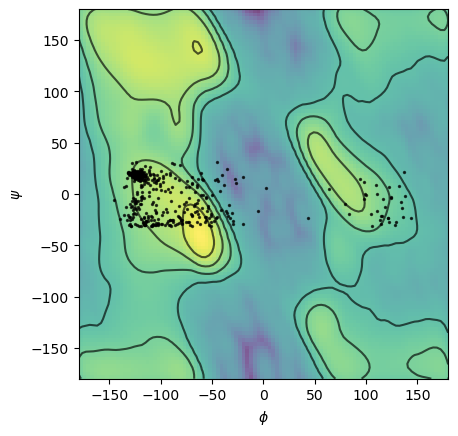

In [252]:
my_sec = secondary_structures(my_prot)
print_secondary_structure(*my_sec[1])

## Contact Map
We define a function to build a contact map from a structure. It should either take as argument a list of structure or a single structure (default).

In [195]:
def contact_maps(structure):
    if isinstance(structure, (list, tuple)):
        return [structure_summary(el) for el in structure]
    elif not isinstance(structure, Structure.Structure):
        raise NotImplementedError()

    return [(structure.id, _contact_map_(chain)) for chain in structure[0]]
    
def _contact_map_(chain):
    residues = [res for res in chain.get_residues() if is_aa(res)]
    cAlpha = [res["CA"] for res in residues]

    # Create a matrix containing the distance between cAlpha
    contact_map = np.zeros((len(cAlpha), len(cAlpha)))
    for col, row in [(col, row) for col in range(len(cAlpha)) for row in range(col, len(cAlpha))]:
        contact_map[row, col] = cAlpha[col] - cAlpha[row]

    return contact_map

def print_contact_map(structure_id, contact_map):
    plt.title(structure_id)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(contact_map, cmap="Greys")
    plt.show()

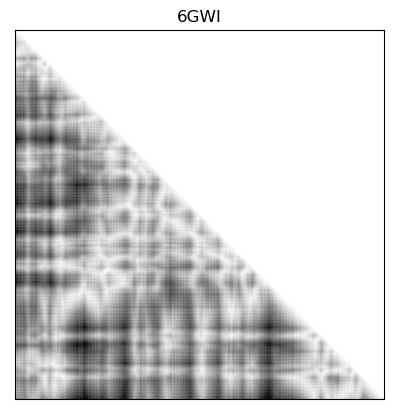

In [202]:
my_maps = contact_maps(my_prot)
print_contact_map(*my_maps[0])